In [2]:
import pandas as pd
import lightgbm as lgb
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time

from matplotlib import gridspec

warnings.filterwarnings(action='ignore')

In [3]:
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

In [11]:
movieData = pd.read_excel("df3_version2.xlsx")
movieData

,영화명,개봉일,매출액,관객수,스크린수,상영횟수,대표국적,국적,배급사,연령등급,장르,러닝타임,감독,개봉월,계절
0,800,2020-12-10,135367500,15549,223,3738,중국,중국,TCO(주)더콘텐츠온,15세 관람가,전쟁,149,관후,12,겨울
1,1917,2020-02-19,7924722960,877017,932,91511,미국,미국,(주)스마일이엔티,15세 관람가,드라마,119,샘 멘데스,2,겨울
2,1987,2017-12-27,58169776145,1942077,1299,27619,한국,한국,(주)씨제이이엔엠,15세 관람가,드라마,129,장준환,12,겨울
3,#살아있다,2020-06-24,15968219900,1903992,1882,137073,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,드라마,98,조일형,6,여름
4,0.0MHz,2019-05-29,1088258860,137294,446,5998,한국,한국,(주)스마일이엔티,15세 관람가,공포,102,유선동,5,봄
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,히트,2011-10-13,783919500,110631,171,5960,한국,한국,(주)넥스트엔터테인먼트월드(NEW),청소년 관람불가,범죄,170,마이클 만,10,가을
2089,히트맨,2007-11-29,1094879000,163414,155,10301,미국,미국,이십세기폭스필름코퍼레이션,청소년 관람불가,액션,92,자비에르 젠스,11,가을
2090,히트맨,2020-01-22,20614278000,2406232,1122,87782,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,코미디,110,최원섭,1,겨울
2091,히트맨: 에이전트 47,2015-09-03,502308500,64157,272,4501,미국,미국,이십세기폭스코리아(주),15세 관람가,액션,98,알렉산더 바흐,9,가을


In [12]:
movieData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2093 entries, 0 to 2092
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   영화명     2093 non-null   object        
 1   개봉일     2093 non-null   datetime64[ns]
 2   매출액     2093 non-null   int64         
 3   관객수     2093 non-null   int64         
 4   스크린수    2093 non-null   int64         
 5   상영횟수    2093 non-null   int64         
 6   대표국적    2093 non-null   object        
 7   국적      2093 non-null   object        
 8   배급사     2093 non-null   object        
 9   연령등급    2093 non-null   object        
 10  장르      2093 non-null   object        
 11  러닝타임    2093 non-null   int64         
 12  감독      2093 non-null   object        
 13  개봉월     2093 non-null   int64         
 14  계절      2093 non-null   object        
dtypes: datetime64[ns](1), int64(6), object(8)
memory usage: 245.4+ KB


In [13]:
movieData.loc[movieData['장르']=='서사', '장르'] = '드라마'

In [14]:
movieData.loc[movieData['장르']=='블랙코미디', '장르'] = '코미디'

In [15]:
movieData['장르'].unique()

array(['전쟁', '드라마', '공포', '액션', '모험', '코미디', 'SF', '범죄', '멜로/로맨스', '스릴러',
       '판타지', '애니메이션', '미스터리', '다큐멘터리', '서스펜스', '가족', '공연실황', '뮤지컬',
       '대한민국', '느와르'], dtype=object)

In [16]:
movieData[movieData['장르'] == '대한민국']

,영화명,개봉일,매출액,관객수,스크린수,상영횟수,대표국적,국적,배급사,연령등급,장르,러닝타임,감독,개봉월,계절
737,명당,2018-09-19,17900775524,2087474,1117,58450,한국,한국,플러스엠 엔터테인먼트,12세 관람가,대한민국,126,박희곤,9,가을
902,번 더 스테이지: 더 무비,2018-11-15,2671391900,315010,243,4714,한국,한국,월트디즈니컴퍼니코리아 유한책임회사,전체 관람가,대한민국,83,박준수,11,가을
1137,스위치,2010-12-01,558483500,82503,162,6854,미국,미국,씨너스엔터테인먼트(주),12세 관람가,대한민국,113,마대윤,12,겨울
1697,천문: 하늘에 묻는다,2019-12-26,16503491020,2000648,2127,68980,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,12세 관람가,대한민국,132,허진호,12,겨울


In [17]:
movieData.loc[737, '장르'] = '시대극'
movieData.loc[902, '장르'] = '다큐멘터리'
movieData.loc[1137, '장르'] = '코미디'
movieData.loc[1697, '장르'] = '시대극'

In [18]:
movieData.loc[movieData['장르']=='서스펜스', '장르'] = '스릴러'

In [19]:
movieData.loc[movieData['장르']=='시대극', '장르'] = '드라마'

In [20]:
movieData['장르'].value_counts()

액션        444
드라마       347
애니메이션     346
코미디       207
범죄        126
공포        117
멜로/로맨스    114
스릴러        86
SF         67
판타지        63
모험         59
미스터리       45
전쟁         17
다큐멘터리      14
가족         14
공연실황       13
뮤지컬        10
느와르         4
Name: 장르, dtype: int64

In [21]:
movieData[movieData['장르'] == '느와르']

,영화명,개봉일,매출액,관객수,스크린수,상영횟수,대표국적,국적,배급사,연령등급,장르,러닝타임,감독,개봉월,계절
835,미옥,2017-11-09,1897705564,238587,635,18099,한국,한국,(주)키다리이엔티,청소년 관람불가,느와르,91,이안규,11,가을
1689,창수,2013-11-28,3146542000,429141,415,19471,한국,한국,(주)마인스 엔터테인먼트,청소년 관람불가,느와르,103,이덕희,11,가을
1716,친구 2,2013-11-14,21795237513,2969900,968,69856,한국,한국,롯데쇼핑㈜롯데엔터테인먼트,청소년 관람불가,느와르,124,곽경택,11,가을
1988,하이힐,2014-06-03,2750311500,341634,385,16750,한국,한국,롯데쇼핑㈜롯데엔터테인먼트,청소년 관람불가,느와르,125,장진,6,여름


In [22]:
movieData['장르'][835] = '범죄'
movieData['장르'][1689] = '드라마'
movieData['장르'][1716] = '액션'
movieData['장르'][1988] = '액션'

In [23]:
movieData['장르'].value_counts()

액션        446
드라마       348
애니메이션     346
코미디       207
범죄        127
공포        117
멜로/로맨스    114
스릴러        86
SF         67
판타지        63
모험         59
미스터리       45
전쟁         17
다큐멘터리      14
가족         14
공연실황       13
뮤지컬        10
Name: 장르, dtype: int64

## EDA

### 장르

In [24]:
genre = movieData.groupby('장르', as_index=False).agg(count = ('장르', 'count')).sort_values('count', ascending=False)
genre

,장르,count
13,액션,446
5,드라마,348
12,애니메이션,346
15,코미디,207
10,범죄,127
3,공포,117
6,멜로/로맨스,114
11,스릴러,86
0,SF,67
16,판타지,63


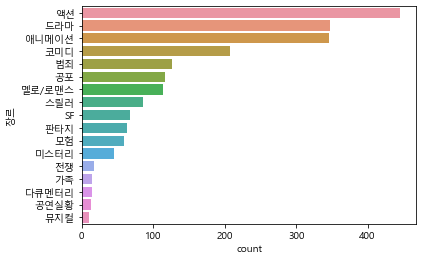

In [25]:
genreGraph = sns.barplot(data = genre, y = '장르', x = 'count')
genreGraph;

In [29]:
# 간단하게 크롤링 사용해서 영화 감독 검색하기

from tqdm import tqdm_notebook # 시간이 오래걸릴 수도 있으므로 얼마나 걸리는지 확인용
from bs4 import BeautifulSoup # 가져온 html 파싱용
from selenium import webdriver # 웹드라이버
from selenium.webdriver.common.by import By # 기능 동작 관련 함수
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time

In [30]:
# 웹 드랄이버 호출 및 url 적용
url = "https://namu.wiki/w/BBC%20%EC%84%A0%EC%A0%95%20'21%EC%84%B8%EA%B8%B0%20%EC%9C%84%EB%8C%80%ED%95%9C%20%EC%98%81%ED%99%94%20100%ED%8E%B8'"
chrome_options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
driver.get(url)

In [31]:
# bbc 선정 21세기 최고의 영화 100선
# 해당페이지 파싱하기
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

# 영화목록 긁어오기
soup.select('a.DCLJQsNO')[2].text # '멀홀랜드 드라이브'
s1 =soup.select('a.DCLJQsNO')
bbc_movie = []
for i in range(2,104):
    bbc_movie.append(s1[i].text)
len(bbc_movie)

102

In [32]:
driver.quit()

In [33]:
url = 'https://search.naver.com/search.naver?where=nexearch&sm=tab_etc&mra=bkEw&pkid=68&os=1756832&qvt=0&query=%EC%98%81%ED%99%94%20%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%89%20%EC%B6%9C%EC%97%B0%EC%A7%84'
chrome_options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
driver.get(url)

director_bbc = []
for each_movie in tqdm_notebook(bbc_movie):
    try :
        # 검색창 클릭하기
        element = driver.find_element(By.XPATH, '//*[@id="nx_query"]')
        element.clear()
        element.click()
        time.sleep(0.5)
    # 검색어 입력 후 엔터
        element.send_keys('영화 '+each_movie+' 출연진')
        element.submit()
    # 해당 페이지 파싱하기
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        director_bbc.append(soup.select('.name ._text')[0].text)
        time.sleep(0.5)
    except:
        director_bbc.append('error')
len(director_bbc)

  0%|          | 0/102 [00:00<?, ?it/s]

102

In [34]:
driver.quit()

In [35]:
for i in  range(len(director_bbc)):
    if director_bbc[i] == 'error':
        print(i, bbc_movie[i])

8 씨민과 나데르의 별거
16 판의 미로
62 토리노의 말
88 머리 없는 여인


In [36]:
director_bbc[8] = '아스가르 파르하디'
director_bbc[16] = '기예르모 델 토로'
director_bbc[62] = '벨라 타르'
director_bbc[88] = '루크레시아 마르텔'
for i in  range(len(director_bbc)):
    if director_bbc[i] == 'error':
        print(i, bbc_movie[i])

In [37]:
for i in  range(len(director_bbc)):
    if director_bbc[i] == 'error':
        print(i, bbc_movie[i])

In [38]:
top500 = pd.read_excel('영화500.xlsx')
top500

,Unnamed: 0,0
0,0,김한민
1,1,이병헌
2,2,김용화
3,3,윤제균
4,4,안소니 루소
...,...,...
495,495,존 추
496,496,이창재
497,497,방은진
498,498,김지운


In [44]:
top500[0]

0         김한민
1         이병헌
2         김용화
3         윤제균
4      안소니 루소
        ...  
495       존 추
496       이창재
497       방은진
498       김지운
499       장문일
Name: 0, Length: 500, dtype: object

In [45]:
top500_list = list(top500[0])

In [46]:
top500_list

['김한민',
 '이병헌',
 '김용화',
 '윤제균',
 '안소니 루소',
 '크리스 벅',
 '제임스 카메론',
 '류승완',
 '봉준호',
 '최동훈',
 '이환경',
 '최동훈',
 '이상용',
 '존 머스커',
 '추창민',
 '이준익',
 '김용화',
 '장훈',
 '강제규',
 '연상호',
 '윤제균',
 '양우석',
 '안소니 루소',
 '강우석',
 '조스 웨던',
 '봉준호',
 '크리스 벅',
 '크리스토퍼 놀란',
 '브라이언 싱어',
 '이일형',
 '올리비에 메가턴',
 '봉준호',
 '한재림',
 '셰인 블랙',
 '안소니 루소',
 '이석훈',
 '황동혁',
 '김종현',
 '심형래',
 '이해준',
 '강형철',
 '조셉 코신스키',
 '존 왓츠',
 '배종',
 '이석훈',
 '마이클 베이',
 '이석훈',
 '브래드 버드',
 '존 왓츠',
 '마이클 베이',
 '김지운',
 '김한민',
 '마이클 베이',
 '강형철',
 '김지훈',
 '김한민',
 '존 왓츠',
 '장준환',
 '류승완',
 '조의석',
 '김성훈',
 '안소니 루소',
 '우민호',
 '이재한',
 '이석훈',
 '이계벽',
 '장철수',
 '나홍진',
 '강윤성',
 '권오광',
 '김지운',
 '조성희',
 '김용화',
 '류승완',
 '크리스토퍼 맥쿼리',
 '크리스토퍼 놀란',
 '이정범',
 '이준익',
 '최동훈',
 '매튜 본',
 '크리스토퍼 맥쿼리',
 '김동원',
 '김학순',
 '피터 잭슨',
 '크리스토퍼 놀란',
 '톰 후퍼',
 '샘 레이미',
 '강제규',
 '애너 보든',
 'J.J. 에이브럼스',
 '후안 안토니오 바요나',
 '김주환',
 '정용기',
 '허정',
 '허진호',
 '카일 랜킨',
 '후안 안토니오 바요나',
 '조의석',
 '장훈',
 '롤란트 에머리히',
 '페이튼 리드',
 '샘 레이미',
 '돈 E. 폰트르로이',
 '김광식',
 '라이언 쿠글러',
 '한재림',
 '이한',
 '마이클 베이',
 '이

In [47]:
# 천만 관객 + BBC

director_add = top500_list + director_bbc
len(director_add)

602

In [48]:
# 공백 제거

for i in range(len(director_add)):
    director_add[i] = director_add[i].replace(' ','')
    

director_add

['김한민',
 '이병헌',
 '김용화',
 '윤제균',
 '안소니루소',
 '크리스벅',
 '제임스카메론',
 '류승완',
 '봉준호',
 '최동훈',
 '이환경',
 '최동훈',
 '이상용',
 '존머스커',
 '추창민',
 '이준익',
 '김용화',
 '장훈',
 '강제규',
 '연상호',
 '윤제균',
 '양우석',
 '안소니루소',
 '강우석',
 '조스웨던',
 '봉준호',
 '크리스벅',
 '크리스토퍼놀란',
 '브라이언싱어',
 '이일형',
 '올리비에메가턴',
 '봉준호',
 '한재림',
 '셰인블랙',
 '안소니루소',
 '이석훈',
 '황동혁',
 '김종현',
 '심형래',
 '이해준',
 '강형철',
 '조셉코신스키',
 '존왓츠',
 '배종',
 '이석훈',
 '마이클베이',
 '이석훈',
 '브래드버드',
 '존왓츠',
 '마이클베이',
 '김지운',
 '김한민',
 '마이클베이',
 '강형철',
 '김지훈',
 '김한민',
 '존왓츠',
 '장준환',
 '류승완',
 '조의석',
 '김성훈',
 '안소니루소',
 '우민호',
 '이재한',
 '이석훈',
 '이계벽',
 '장철수',
 '나홍진',
 '강윤성',
 '권오광',
 '김지운',
 '조성희',
 '김용화',
 '류승완',
 '크리스토퍼맥쿼리',
 '크리스토퍼놀란',
 '이정범',
 '이준익',
 '최동훈',
 '매튜본',
 '크리스토퍼맥쿼리',
 '김동원',
 '김학순',
 '피터잭슨',
 '크리스토퍼놀란',
 '톰후퍼',
 '샘레이미',
 '강제규',
 '애너보든',
 'J.J.에이브럼스',
 '후안안토니오바요나',
 '김주환',
 '정용기',
 '허정',
 '허진호',
 '카일랜킨',
 '후안안토니오바요나',
 '조의석',
 '장훈',
 '롤란트에머리히',
 '페이튼리드',
 '샘레이미',
 '돈E.폰트르로이',
 '김광식',
 '라이언쿠글러',
 '한재림',
 '이한',
 '마이클베이',
 '이재규',
 '봉준호',
 '토드필립스',
 '마크포스터',
 '피터잭슨',
 

In [49]:
len(director_add)

602

In [50]:
# 감독 인코딩

le_list = []
for i in movieData['감독']:
    if i in director_add:
        le_list.append(1.)
    else:
        le_list.append(0.)

len(le_list)

2093

In [52]:
movieData

,영화명,개봉일,매출액,관객수,스크린수,상영횟수,대표국적,국적,배급사,연령등급,장르,러닝타임,감독,개봉월,계절
0,800,2020-12-10,135367500,15549,223,3738,중국,중국,TCO(주)더콘텐츠온,15세 관람가,전쟁,149,관후,12,겨울
1,1917,2020-02-19,7924722960,877017,932,91511,미국,미국,(주)스마일이엔티,15세 관람가,드라마,119,샘 멘데스,2,겨울
2,1987,2017-12-27,58169776145,1942077,1299,27619,한국,한국,(주)씨제이이엔엠,15세 관람가,드라마,129,장준환,12,겨울
3,#살아있다,2020-06-24,15968219900,1903992,1882,137073,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,드라마,98,조일형,6,여름
4,0.0MHz,2019-05-29,1088258860,137294,446,5998,한국,한국,(주)스마일이엔티,15세 관람가,공포,102,유선동,5,봄
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,히트,2011-10-13,783919500,110631,171,5960,한국,한국,(주)넥스트엔터테인먼트월드(NEW),청소년 관람불가,범죄,170,마이클 만,10,가을
2089,히트맨,2007-11-29,1094879000,163414,155,10301,미국,미국,이십세기폭스필름코퍼레이션,청소년 관람불가,액션,92,자비에르 젠스,11,가을
2090,히트맨,2020-01-22,20614278000,2406232,1122,87782,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,코미디,110,최원섭,1,겨울
2091,히트맨: 에이전트 47,2015-09-03,502308500,64157,272,4501,미국,미국,이십세기폭스코리아(주),15세 관람가,액션,98,알렉산더 바흐,9,가을


In [53]:
movieData['le_감독'] = le_list
movieData

,영화명,개봉일,매출액,관객수,스크린수,상영횟수,대표국적,국적,배급사,연령등급,장르,러닝타임,감독,개봉월,계절,le_감독
0,800,2020-12-10,135367500,15549,223,3738,중국,중국,TCO(주)더콘텐츠온,15세 관람가,전쟁,149,관후,12,겨울,0.0
1,1917,2020-02-19,7924722960,877017,932,91511,미국,미국,(주)스마일이엔티,15세 관람가,드라마,119,샘 멘데스,2,겨울,0.0
2,1987,2017-12-27,58169776145,1942077,1299,27619,한국,한국,(주)씨제이이엔엠,15세 관람가,드라마,129,장준환,12,겨울,1.0
3,#살아있다,2020-06-24,15968219900,1903992,1882,137073,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,드라마,98,조일형,6,여름,1.0
4,0.0MHz,2019-05-29,1088258860,137294,446,5998,한국,한국,(주)스마일이엔티,15세 관람가,공포,102,유선동,5,봄,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,히트,2011-10-13,783919500,110631,171,5960,한국,한국,(주)넥스트엔터테인먼트월드(NEW),청소년 관람불가,범죄,170,마이클 만,10,가을,0.0
2089,히트맨,2007-11-29,1094879000,163414,155,10301,미국,미국,이십세기폭스필름코퍼레이션,청소년 관람불가,액션,92,자비에르 젠스,11,가을,0.0
2090,히트맨,2020-01-22,20614278000,2406232,1122,87782,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,코미디,110,최원섭,1,겨울,1.0
2091,히트맨: 에이전트 47,2015-09-03,502308500,64157,272,4501,미국,미국,이십세기폭스코리아(주),15세 관람가,액션,98,알렉산더 바흐,9,가을,0.0


In [54]:
movieData['le_감독'].value_counts()

0.0    1717
1.0     376
Name: le_감독, dtype: int64

In [55]:
movieData.corr().round(1)

,매출액,관객수,스크린수,상영횟수,러닝타임,개봉월,le_감독
매출액,1.0,1.0,0.7,0.9,0.3,0.1,0.4
관객수,1.0,1.0,0.7,0.9,0.3,0.0,0.4
스크린수,0.7,0.7,1.0,0.8,0.3,0.1,0.3
상영횟수,0.9,0.9,0.8,1.0,0.3,0.0,0.4
러닝타임,0.3,0.3,0.3,0.3,1.0,0.0,0.2
개봉월,0.1,0.0,0.1,0.0,0.0,1.0,0.0
le_감독,0.4,0.4,0.3,0.4,0.2,0.0,1.0


In [56]:
movieData_test = movieData.copy()

In [57]:
bae_top100 = pd.read_csv('./2019영화사순위TOP100.csv', encoding='euc-kr')

In [58]:
movieData_test = movieData_test.replace({'배급사' : 'CJ E&M'}, 'CJ ENM')
movieData_test = movieData_test.replace({'배급사' : '(주)씨제이이엔엠'}, 'CJ ENM')
movieData_test = movieData_test.replace({'배급사' : '한국소니픽쳐스릴리징브에나비스타영화㈜'}, '소니 픽쳐스 코리아')
movieData_test = movieData_test.replace({'배급사' : '소니픽쳐스릴리징월트디즈니스튜디오스코리아(주)'}, '소니 픽쳐스')
movieData_test = movieData_test.replace({'배급사' : '워너브러더스 코리아(주)'}, '워너브러더스 코리아') 
movieData_test = movieData_test.replace({'배급사' : '월트디즈니코리아㈜'}, '월트 디즈니 컴패니 코리아')
top100_name = []

for i in bae_top100['배급사명']:
    top100_name.append(i)

top100_name
TF_ = []

for i in movieData_test['배급사']:
    print(i)
    if i in top100_name:
        TF_.append(1)
        
    else:
        TF_.append(0)

TCO(주)더콘텐츠온
(주)스마일이엔티
CJ ENM
롯데컬처웍스(주)롯데엔터테인먼트
(주)스마일이엔티
유니버설픽쳐스인터내셔널 코리아(유)
소니 픽쳐스
유니버설픽쳐스인터내셔널 코리아(유)
소니 픽쳐스 코리아
소니 픽쳐스 코리아
워너브러더스 코리아
(주)싸이더스
이십세기폭스코리아(주)
㈜케이디미디어
롯데쇼핑㈜롯데엔터테인먼트
CJ ENM
롯데쇼핑㈜롯데엔터테인먼트
(주)싸이더스
유니버설픽쳐스인터내셔널 코리아(유)
유니버설픽쳐스인터내셔널 코리아(유)
(주)리틀빅픽쳐스
CJ ENM
소니 픽쳐스 코리아
㈜메가박스
소니 픽쳐스 코리아
(주)드림팩트엔터테인먼트
㈜케이디미디어
유니버설픽쳐스인터내셔널 코리아(유)
(주)인벤트스톤
이십세기폭스필름코퍼레이션
워너브러더스 코리아
워너브러더스 코리아
(주)쇼박스
(주)키다리이엔티
TCO(주)더콘텐츠온
롯데쇼핑㈜롯데엔터테인먼트
유니버설픽쳐스인터내셔널 코리아(유)
유니버설픽쳐스인터내셔널 코리아(유)
필라멘트픽쳐스
CJ ENM
(주)스튜디오210
CJ ENM
롯데쇼핑㈜롯데엔터테인먼트
CJ ENM
(주)넥스트엔터테인먼트월드(NEW)
유니버설픽쳐스인터내셔널 코리아(유)
롯데쇼핑㈜롯데엔터테인먼트
롯데컬처웍스(주)롯데엔터테인먼트
(주)프라임엔터테인먼트
(주)팝엔터테인먼트
에스케이텔레콤(주)
이십세기폭스코리아(주)
㈜스튜디오이쩜영
와이드 릴리즈(주)
(주)쇼박스
롯데쇼핑㈜롯데엔터테인먼트
(주)쇼박스
CJ ENM
유니버설픽쳐스인터내셔널 코리아(유)
CJ ENM
(주)싸이더스
(재)CBS
워너브러더스 코리아
CJ ENM
소니 픽쳐스
월트디즈니컴퍼니코리아 유한책임회사
(주)쇼박스
(주)쇼박스
롯데쇼핑㈜롯데엔터테인먼트
(주)넥스트엔터테인먼트월드(NEW)
롯데쇼핑㈜롯데엔터테인먼트
(주)시네마서비스
(주)인벤트스톤
(주)넥스트엔터테인먼트월드(NEW)
㈜케이디미디어
(주)쇼박스
롯데쇼핑㈜롯데엔터테인먼트
롯데쇼핑㈜롯데엔터테인먼트
아이러브시네마
(주)넥스트엔터테인먼트월드(NEW)
플러스엠 엔터테인먼트
(주)시네마서비스
(주)쇼박스
(주)스튜디오 산타클로스엔터테인먼트


In [63]:
TF_.count(1), TF_.count(0)

(437, 1656)

In [64]:
movieData_test['le_배급사'] = TF_

In [66]:
movieData_test.corr().round(1)

,매출액,관객수,스크린수,상영횟수,러닝타임,개봉월,le_감독,le_배급사
매출액,1.0,1.0,0.7,0.9,0.3,0.1,0.4,0.0
관객수,1.0,1.0,0.7,0.9,0.3,0.0,0.4,0.0
스크린수,0.7,0.7,1.0,0.8,0.3,0.1,0.3,0.0
상영횟수,0.9,0.9,0.8,1.0,0.3,0.0,0.4,0.0
러닝타임,0.3,0.3,0.3,0.3,1.0,0.0,0.2,0.1
개봉월,0.1,0.0,0.1,0.0,0.0,1.0,0.0,0.0
le_감독,0.4,0.4,0.3,0.4,0.2,0.0,1.0,-0.0
le_배급사,0.0,0.0,0.0,0.0,0.1,0.0,-0.0,1.0


In [69]:
movieData = movieData_test

In [70]:
directorScore = pd.read_excel('감독_참여작수.xlsx')

In [71]:
directorScore

,영화명,감독,참여작수
0,800,관후,1
1,1917,샘 멘데스,20
2,1987,장준환,14
3,#살아있다,조일형,1
4,0.0MHz,유선동,6
...,...,...,...
2088,히트,마이클 만,23
2089,히트맨,자비에르 젠스,15
2090,히트맨,최원섭,6
2091,히트맨: 에이전트 47,알렉산더 바흐,2


In [72]:
movieData['감독_참여작수'] = directorScore['참여작수']
movieData

,영화명,개봉일,매출액,관객수,스크린수,상영횟수,대표국적,국적,배급사,연령등급,장르,러닝타임,감독,개봉월,계절,le_감독,le_배급사,감독_참여작수
0,800,2020-12-10,135367500,15549,223,3738,중국,중국,TCO(주)더콘텐츠온,15세 관람가,전쟁,149,관후,12,겨울,0.0,0,1
1,1917,2020-02-19,7924722960,877017,932,91511,미국,미국,(주)스마일이엔티,15세 관람가,드라마,119,샘 멘데스,2,겨울,0.0,1,20
2,1987,2017-12-27,58169776145,1942077,1299,27619,한국,한국,CJ ENM,15세 관람가,드라마,129,장준환,12,겨울,1.0,0,14
3,#살아있다,2020-06-24,15968219900,1903992,1882,137073,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,드라마,98,조일형,6,여름,1.0,0,1
4,0.0MHz,2019-05-29,1088258860,137294,446,5998,한국,한국,(주)스마일이엔티,15세 관람가,공포,102,유선동,5,봄,0.0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,히트,2011-10-13,783919500,110631,171,5960,한국,한국,(주)넥스트엔터테인먼트월드(NEW),청소년 관람불가,범죄,170,마이클 만,10,가을,0.0,0,23
2089,히트맨,2007-11-29,1094879000,163414,155,10301,미국,미국,이십세기폭스필름코퍼레이션,청소년 관람불가,액션,92,자비에르 젠스,11,가을,0.0,0,15
2090,히트맨,2020-01-22,20614278000,2406232,1122,87782,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,코미디,110,최원섭,1,겨울,1.0,0,6
2091,히트맨: 에이전트 47,2015-09-03,502308500,64157,272,4501,미국,미국,이십세기폭스코리아(주),15세 관람가,액션,98,알렉산더 바흐,9,가을,0.0,0,2


In [73]:
# movieData 저장

movieData.to_excel('movieData.xlsx', index=False)

In [75]:
# movieData 저장

movieData.to_excel('df5.xlsx', index=False)

In [76]:
movieDataTest = pd.read_excel('df5.xlsx')
movieDataTest

,영화명,개봉일,매출액,관객수,스크린수,상영횟수,대표국적,국적,배급사,연령등급,장르,러닝타임,감독,개봉월,계절,le_감독,le_배급사,감독_참여작수
0,800,2020-12-10,135367500,15549,223,3738,중국,중국,TCO(주)더콘텐츠온,15세 관람가,전쟁,149,관후,12,겨울,0,0,1
1,1917,2020-02-19,7924722960,877017,932,91511,미국,미국,(주)스마일이엔티,15세 관람가,드라마,119,샘 멘데스,2,겨울,0,1,20
2,1987,2017-12-27,58169776145,1942077,1299,27619,한국,한국,CJ ENM,15세 관람가,드라마,129,장준환,12,겨울,1,0,14
3,#살아있다,2020-06-24,15968219900,1903992,1882,137073,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,드라마,98,조일형,6,여름,1,0,1
4,0.0MHz,2019-05-29,1088258860,137294,446,5998,한국,한국,(주)스마일이엔티,15세 관람가,공포,102,유선동,5,봄,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,히트,2011-10-13,783919500,110631,171,5960,한국,한국,(주)넥스트엔터테인먼트월드(NEW),청소년 관람불가,범죄,170,마이클 만,10,가을,0,0,23
2089,히트맨,2007-11-29,1094879000,163414,155,10301,미국,미국,이십세기폭스필름코퍼레이션,청소년 관람불가,액션,92,자비에르 젠스,11,가을,0,0,15
2090,히트맨,2020-01-22,20614278000,2406232,1122,87782,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,코미디,110,최원섭,1,겨울,1,0,6
2091,히트맨: 에이전트 47,2015-09-03,502308500,64157,272,4501,미국,미국,이십세기폭스코리아(주),15세 관람가,액션,98,알렉산더 바흐,9,가을,0,0,2


## one-hot

In [77]:
movieDataTest_getDummies = pd.get_dummies(movieDataTest, columns=['대표국적', '연령등급', '장르', '개봉월', '계절'])
movieDataTest_getDummies

,영화명,개봉일,매출액,관객수,스크린수,상영횟수,국적,배급사,러닝타임,감독,...,개봉월_7,개봉월_8,개봉월_9,개봉월_10,개봉월_11,개봉월_12,계절_가을,계절_겨울,계절_봄,계절_여름
0,800,2020-12-10,135367500,15549,223,3738,중국,TCO(주)더콘텐츠온,149,관후,...,0,0,0,0,0,1,0,1,0,0
1,1917,2020-02-19,7924722960,877017,932,91511,미국,(주)스마일이엔티,119,샘 멘데스,...,0,0,0,0,0,0,0,1,0,0
2,1987,2017-12-27,58169776145,1942077,1299,27619,한국,CJ ENM,129,장준환,...,0,0,0,0,0,1,0,1,0,0
3,#살아있다,2020-06-24,15968219900,1903992,1882,137073,한국,롯데컬처웍스(주)롯데엔터테인먼트,98,조일형,...,0,0,0,0,0,0,0,0,0,1
4,0.0MHz,2019-05-29,1088258860,137294,446,5998,한국,(주)스마일이엔티,102,유선동,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,히트,2011-10-13,783919500,110631,171,5960,한국,(주)넥스트엔터테인먼트월드(NEW),170,마이클 만,...,0,0,0,1,0,0,1,0,0,0
2089,히트맨,2007-11-29,1094879000,163414,155,10301,미국,이십세기폭스필름코퍼레이션,92,자비에르 젠스,...,0,0,0,0,1,0,1,0,0,0
2090,히트맨,2020-01-22,20614278000,2406232,1122,87782,한국,롯데컬처웍스(주)롯데엔터테인먼트,110,최원섭,...,0,0,0,0,0,0,0,1,0,0
2091,히트맨: 에이전트 47,2015-09-03,502308500,64157,272,4501,미국,이십세기폭스코리아(주),98,알렉산더 바흐,...,0,0,1,0,0,0,1,0,0,0


In [83]:
movieCorr_all = movieDataTest_getDummies.corr()

In [84]:
movieCorr_all.columns

Index(['매출액', '관객수', '스크린수', '상영횟수', '러닝타임', 'le_감독', 'le_배급사', '감독_참여작수',
       '대표국적_기타', '대표국적_남아프리카공화국', '대표국적_네덜란드', '대표국적_덴마크', '대표국적_독일',
       '대표국적_러시아', '대표국적_미국', '대표국적_벨기에', '대표국적_스웨덴', '대표국적_스페인', '대표국적_아이슬란드',
       '대표국적_영국', '대표국적_우크라이나', '대표국적_인도', '대표국적_일본', '대표국적_중국', '대표국적_캐나다',
       '대표국적_태국', '대표국적_페루', '대표국적_프랑스', '대표국적_핀란드', '대표국적_한국', '대표국적_헝가리',
       '대표국적_호주', '대표국적_홍콩', '연령등급_12세 관람가', '연령등급_15세 관람가', '연령등급_전체 관람가',
       '연령등급_청소년 관람불가', '장르_SF', '장르_가족', '장르_공연실황', '장르_공포', '장르_다큐멘터리',
       '장르_드라마', '장르_멜로/로맨스', '장르_모험', '장르_뮤지컬', '장르_미스터리', '장르_범죄', '장르_스릴러',
       '장르_애니메이션', '장르_액션', '장르_전쟁', '장르_코미디', '장르_판타지', '개봉월_1', '개봉월_2',
       '개봉월_3', '개봉월_4', '개봉월_5', '개봉월_6', '개봉월_7', '개봉월_8', '개봉월_9', '개봉월_10',
       '개봉월_11', '개봉월_12', '계절_가을', '계절_겨울', '계절_봄', '계절_여름'],
      dtype='object')

In [90]:
movieCorr_all[['매출액', '계절_가을', '계절_겨울', '계절_봄', '계절_여름']]

,매출액,계절_가을,계절_겨울,계절_봄,계절_여름
매출액,1.000000,-0.046423,-0.020956,-0.039719,0.108059
관객수,0.990639,-0.048928,-0.023132,-0.041976,0.115114
스크린수,0.686739,-0.024813,0.013737,-0.039994,0.049402
상영횟수,0.913051,0.005348,-0.067227,-0.003436,0.069507
러닝타임,0.326313,-0.034397,0.026566,0.038172,-0.030370
...,...,...,...,...,...
개봉월_12,0.038296,-0.186438,0.509442,-0.174172,-0.184110
계절_가을,-0.046423,1.000000,-0.370679,-0.306681,-0.324178
계절_겨울,-0.020956,-0.370679,1.000000,-0.339525,-0.358896
계절_봄,-0.039719,-0.306681,-0.339525,1.000000,-0.296932


## EDA

In [94]:
from matplotlib import rc

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 때문에 한글이 깨질 수 있어 주는 설정

rc('font', family='NanumGothic')
# %matplotlib inline
get_ipython().run_line_magic('matplotlib', 'inline')

In [125]:
movieDataTest_getDummies.columns

Index(['영화명', '개봉일', '매출액', '관객수', '스크린수', '상영횟수', '국적', '배급사', '러닝타임', '감독',
       'le_감독', 'le_배급사', '감독_참여작수', '대표국적_기타', '대표국적_남아프리카공화국', '대표국적_네덜란드',
       '대표국적_덴마크', '대표국적_독일', '대표국적_러시아', '대표국적_미국', '대표국적_벨기에', '대표국적_스웨덴',
       '대표국적_스페인', '대표국적_아이슬란드', '대표국적_영국', '대표국적_우크라이나', '대표국적_인도', '대표국적_일본',
       '대표국적_중국', '대표국적_캐나다', '대표국적_태국', '대표국적_페루', '대표국적_프랑스', '대표국적_핀란드',
       '대표국적_한국', '대표국적_헝가리', '대표국적_호주', '대표국적_홍콩', '연령등급_12세 관람가',
       '연령등급_15세 관람가', '연령등급_전체 관람가', '연령등급_청소년 관람불가', '장르_SF', '장르_가족',
       '장르_공연실황', '장르_공포', '장르_다큐멘터리', '장르_드라마', '장르_멜로/로맨스', '장르_모험',
       '장르_뮤지컬', '장르_미스터리', '장르_범죄', '장르_스릴러', '장르_애니메이션', '장르_액션', '장르_전쟁',
       '장르_코미디', '장르_판타지', '개봉월_1', '개봉월_2', '개봉월_3', '개봉월_4', '개봉월_5',
       '개봉월_6', '개봉월_7', '개봉월_8', '개봉월_9', '개봉월_10', '개봉월_11', '개봉월_12',
       '계절_가을', '계절_겨울', '계절_봄', '계절_여름'],
      dtype='object')

#### 연속형 변수 히트맵

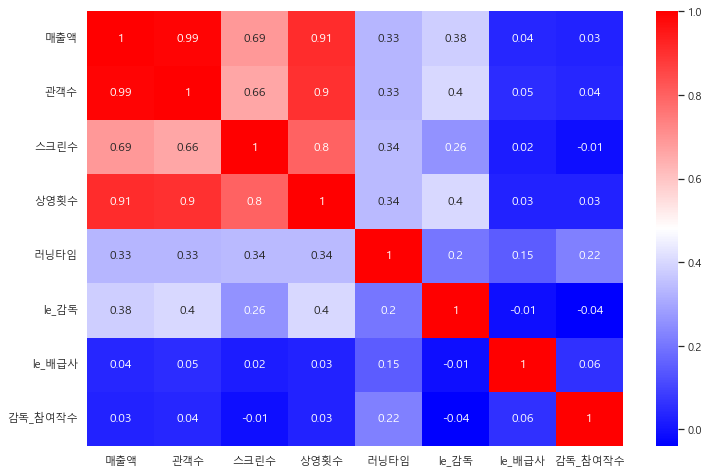

In [126]:
plt.figure(figsize=(12,8))
corr_mat = movieDataTest_getDummies[['영화명', '개봉일', '매출액', '관객수', '스크린수', '상영횟수', '국적', '배급사', '러닝타임', '감독','le_감독', 'le_배급사', '감독_참여작수']].corr().round(2)
sns.heatmap(data=corr_mat, annot=True, cmap='bwr');

#### 범주형 변수 히트맵(국가)

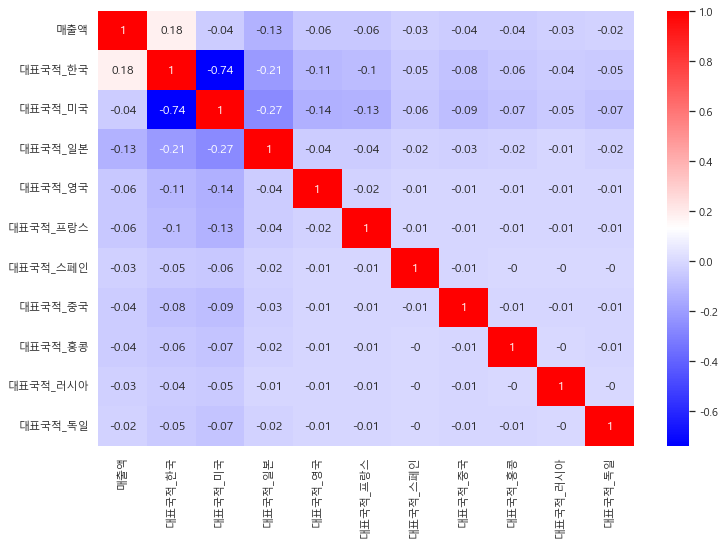

In [128]:
plt.figure(figsize=(12,8))
corr_mat = movieDataTest_getDummies[['매출액', '대표국적_한국', '대표국적_미국', '대표국적_일본', '대표국적_영국', '대표국적_프랑스', '대표국적_스페인', '대표국적_중국', '대표국적_홍콩', '대표국적_러시아', '대표국적_독일']].corr().round(2)
sns.heatmap(data=corr_mat, annot=True, cmap='bwr');

- 그렇게 큰 영향은 없다

#### 계절 히트맵

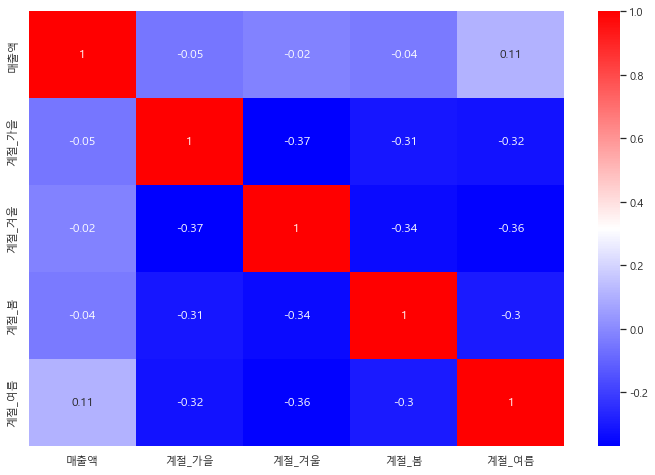

In [129]:
plt.figure(figsize=(12,8))
corr_mat = movieDataTest_getDummies[['매출액', '계절_가을', '계절_겨울', '계절_봄', '계절_여름']].corr().round(2)
sns.heatmap(data=corr_mat, annot=True, cmap='bwr');

#### 연령등급 히트맵

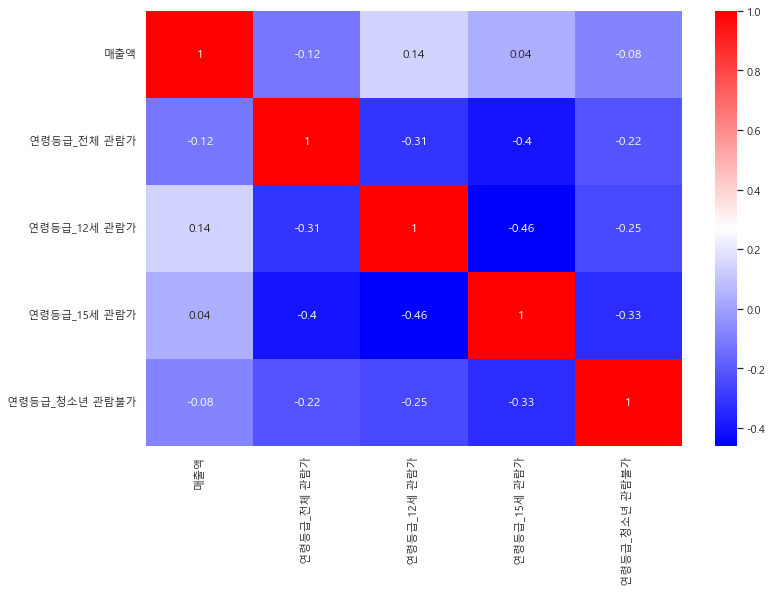

In [131]:
plt.figure(figsize=(12,8))
corr_mat = movieDataTest_getDummies[['매출액', '연령등급_전체 관람가', '연령등급_12세 관람가', '연령등급_15세 관람가', '연령등급_청소년 관람불가']].corr().round(2)
sns.heatmap(data=corr_mat, annot=True, cmap='bwr');

#### 장르 히트맵

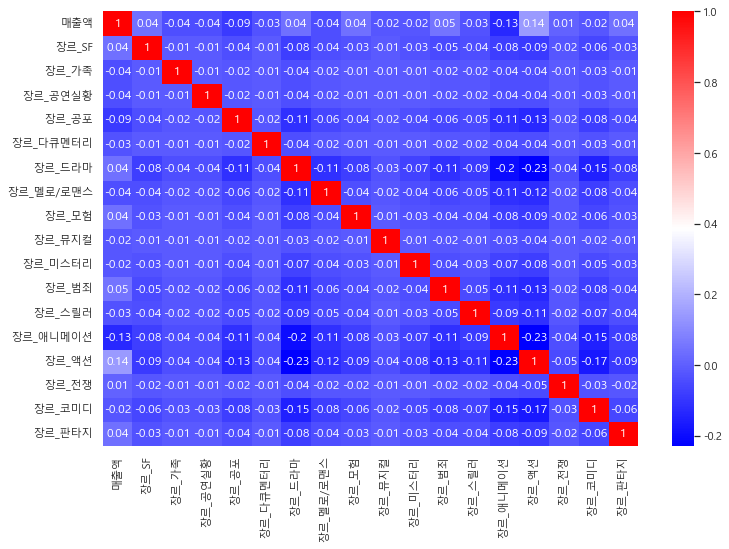

In [132]:
plt.figure(figsize=(12,8))
corr_mat = movieDataTest_getDummies[['매출액', '장르_SF', '장르_가족', '장르_공연실황', '장르_공포', '장르_다큐멘터리', '장르_드라마', '장르_멜로/로맨스', '장르_모험', '장르_뮤지컬', '장르_미스터리', '장르_범죄', '장르_스릴러', '장르_애니메이션', '장르_액션', '장르_전쟁', '장르_코미디', '장르_판타지']].corr().round(2)
sns.heatmap(data=corr_mat, annot=True, cmap='bwr');

In [120]:
genre = movieData.groupby('장르', as_index=False).agg(count = ('장르', 'count')).sort_values('count', ascending=False)
genre

,장르,count
13,액션,446
5,드라마,348
12,애니메이션,346
15,코미디,207
10,범죄,127
3,공포,117
6,멜로/로맨스,114
11,스릴러,86
0,SF,67
16,판타지,63


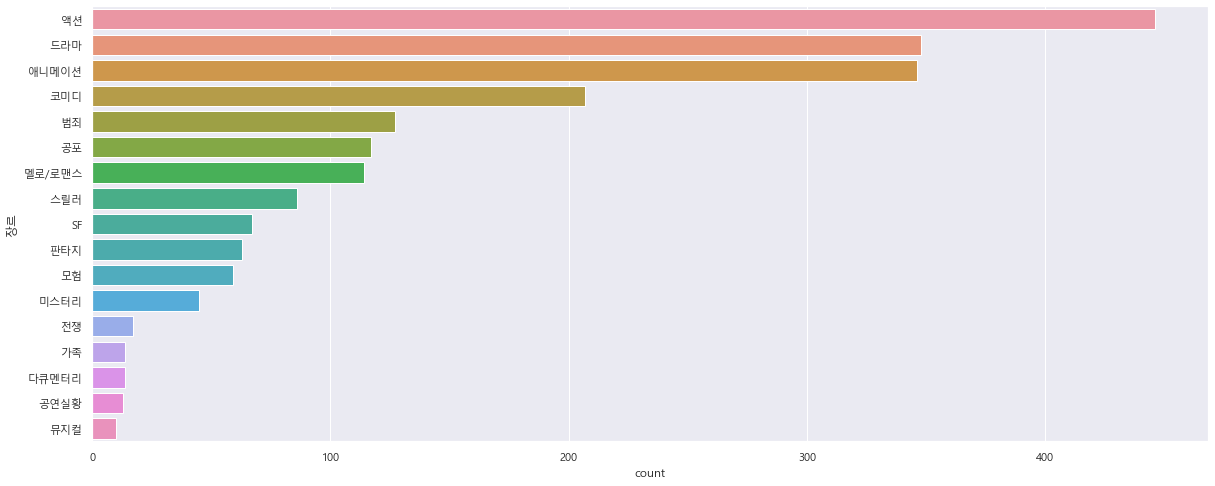

In [121]:
sns.barplot(data = genre, y = '장르', x = 'count');

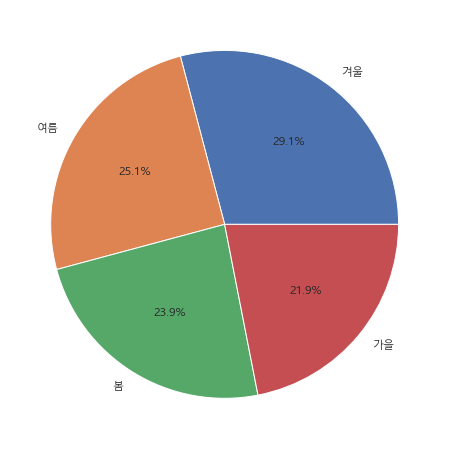

In [119]:
import matplotlib.pyplot as plt

plt.pie(movieData['계절'].value_counts(),labels=movieData['계절'].unique(),autopct='%.1f%%')
plt.show()

In [122]:
import plotly.express as px

fig = px.histogram(movieDataTest, x='매출액')
fig.show()

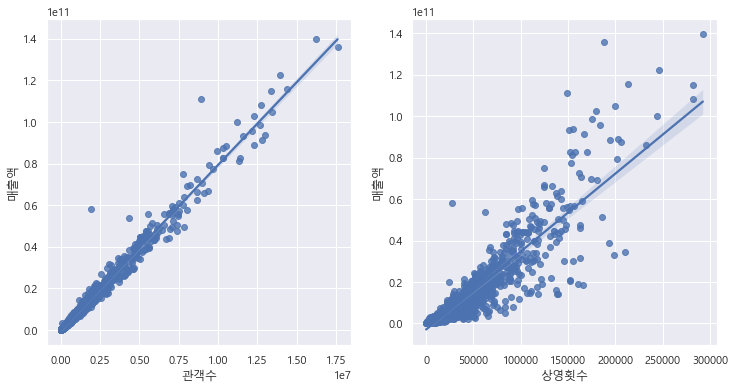

In [96]:
sns.set_style('darkgrid')
sns.set(rc = {'figure.figsize':(12,6)})
plt.rcParams['font.family'] = 'Malgun Gothic'
fig, ax = plt.subplots(ncols=2)

sns.regplot(x='관객수', y='매출액', data=movieData, ax=ax[0])
sns.regplot(x='상영횟수', y='매출액', data=movieData, ax=ax[1])
plt.show();

In [97]:
# 스크린수 하위 7
movieData.sort_values('스크린수', ascending=True).head(7)

,영화명,개봉일,매출액,관객수,스크린수,상영횟수,대표국적,국적,배급사,연령등급,장르,러닝타임,감독,개봉월,계절,le_감독,le_배급사,감독_참여작수
614,레플리카,2019-09-25,63683000,8102,13,87,미국,미국,(주)제이앤씨미디어그룹,15세 관람가,범죄,107,제프리 나크마노프,9,가을,0.0,0,6
1996,할로윈: 살인마 잭,2020-07-21,39400520,7985,16,110,영국,영국,(주)영화사 안다미로,15세 관람가,공포,83,앤드류 존스,7,여름,0.0,0,15
1652,죽이는 여자,2020-08-23,35852000,8858,17,104,미국,미국,(주)영화사 안다미로,청소년 관람불가,공포,82,애쉴리 해밀턴,8,여름,0.0,0,4
473,덩케르크,2017-07-20,117630000,12033,17,517,미국,"미국,영국",워너브러더스 코리아,15세 관람가,전쟁,87,크리스토퍼 놀란,7,여름,0.0,1,27
1117,쉬즈 더 맨,2007-05-03,775034000,124354,19,2322,미국,"미국,캐나다",㈜메가박스,12세 관람가,코미디,104,앤디 픽맨,5,봄,0.0,0,9
796,무협: 더 코드,2020-06-22,35376040,8371,19,109,미국,미국,(주)영화사 안다미로,15세 관람가,액션,79,조니 우,6,여름,0.0,0,3
1426,오페라의 유령 : 25주년 특별 공연,2011-12-15,1136679000,65104,24,1205,영국,영국,유니버설픽쳐스인터내셔널 코리아(유),전체 관람가,공연실황,175,캐머런 맥킨토시,12,겨울,0.0,0,7


In [98]:
# 스크린수 상위 7
movieData.sort_values('스크린수', ascending=False).head(7)
# 스크린수가 적지만 100배차이나는 작품보다 높은 경우가 보인다.

,영화명,개봉일,매출액,관객수,스크린수,상영횟수,대표국적,국적,배급사,연령등급,장르,러닝타임,감독,개봉월,계절,le_감독,le_배급사,감독_참여작수
1471,원더 우먼 1984,2020-12-23,4947583400,548695,4137,83703,미국,미국,워너브러더스 코리아,12세 관람가,액션,151,패티 젠킨스,12,겨울,0.0,1,11
1197,신과함께-죄와 벌,2017-12-20,115706080137,14411502,3556,213262,한국,한국,롯데쇼핑㈜롯데엔터테인먼트,12세 관람가,판타지,139,김용화,12,겨울,1.0,0,14
1329,어벤져스: 엔드게임,2019-04-24,122492181020,13977602,3352,246433,미국,미국,월트디즈니컴퍼니코리아 유한책임회사,12세 관람가,액션,181,안소니 루소,4,봄,0.0,0,15
888,백두산,2019-12-19,69826806300,8252909,3212,174328,한국,한국,CJ ENM,12세 관람가,드라마,128,이해준,12,겨울,1.0,0,12
1330,어벤져스: 인피니티 워,2018-04-25,100081428549,11233176,2985,243677,미국,미국,월트디즈니컴퍼니코리아 유한책임회사,12세 관람가,액션,149,안소니 루소,4,봄,0.0,0,15
1167,스파이더맨: 노 웨이 홈,2021-12-15,55697413760,5560940,2948,144754,미국,미국,소니픽쳐스엔터테인먼트코리아주식회사극장배급지점,12세 관람가,액션,156,존 왓츠,12,겨울,0.0,0,6
678,마스터,2016-12-21,58068236865,7150586,2746,126927,한국,한국,CJ ENM,15세 관람가,액션,143,조의석,12,겨울,1.0,0,8


In [419]:
movieData

,영화명,개봉일,매출액,관객수,스크린수,상영횟수,대표국적,국적,배급사,연령등급,장르,러닝타임,감독,개봉월,계절,le_감독,le_배급사,감독_참여작수
0,800,2020-12-10,135367500,15549,223,3738,중국,중국,TCO(주)더콘텐츠온,15세 관람가,전쟁,149,관후,12,겨울,0.0,0,1
1,1917,2020-02-19,7924722960,877017,932,91511,미국,미국,(주)스마일이엔티,15세 관람가,드라마,119,샘 멘데스,2,겨울,0.0,1,20
2,1987,2017-12-27,58169776145,1942077,1299,27619,한국,한국,CJ ENM,15세 관람가,드라마,129,장준환,12,겨울,1.0,0,14
3,#살아있다,2020-06-24,15968219900,1903992,1882,137073,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,드라마,98,조일형,6,여름,1.0,0,1
4,0.0MHz,2019-05-29,1088258860,137294,446,5998,한국,한국,(주)스마일이엔티,15세 관람가,공포,102,유선동,5,봄,0.0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,히트,2011-10-13,783919500,110631,171,5960,한국,한국,(주)넥스트엔터테인먼트월드(NEW),청소년 관람불가,범죄,170,마이클 만,10,가을,0.0,0,23
2089,히트맨,2007-11-29,1094879000,163414,155,10301,미국,미국,이십세기폭스필름코퍼레이션,청소년 관람불가,액션,92,자비에르 젠스,11,가을,0.0,0,15
2090,히트맨,2020-01-22,20614278000,2406232,1122,87782,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,코미디,110,최원섭,1,겨울,1.0,0,6
2091,히트맨: 에이전트 47,2015-09-03,502308500,64157,272,4501,미국,미국,이십세기폭스코리아(주),15세 관람가,액션,98,알렉산더 바흐,9,가을,0.0,0,2


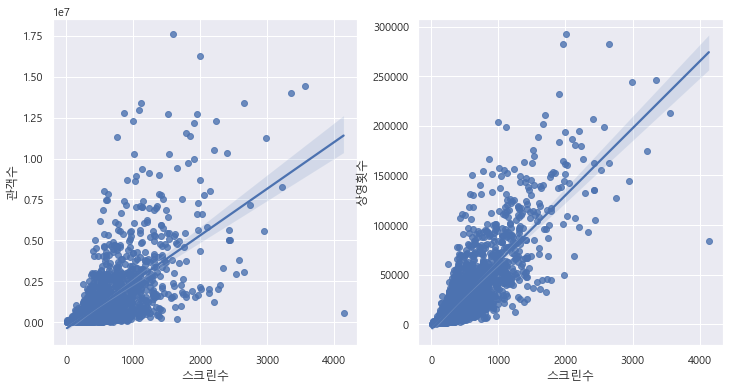

In [100]:
# 스크린수 와  관객수, 상영횟수 상관관계 분포도
sns.set_style('darkgrid')
sns.set(rc = {'figure.figsize':(12,6)})
plt.rcParams['font.family'] = 'Malgun Gothic'
fig, ax = plt.subplots(ncols=2)

sns.regplot(x='스크린수', y='관객수', data=movieData, ax=ax[0])
sns.regplot(x='스크린수', y='상영횟수', data=movieData, ax=ax[1])
plt.show();

<AxesSubplot:ylabel='러닝타임'>

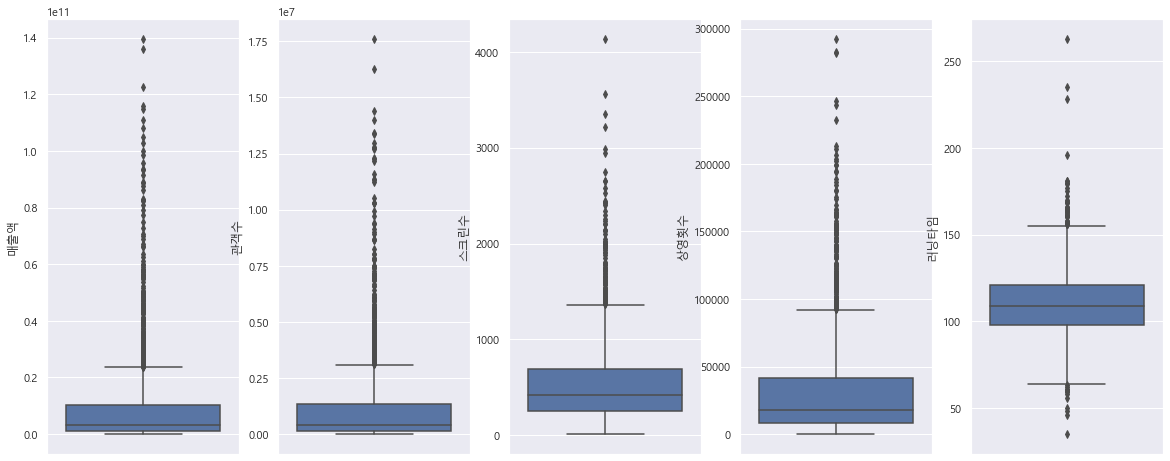

In [105]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (20, 8)})
plt.rcParams['font.family'] = 'Malgun Gothic'

fig, ax = plt.subplots(ncols=5, nrows=1)
sns.boxplot(y='매출액', data=movieData, ax=ax[0])
sns.boxplot(y='관객수', data=movieData, ax=ax[1])
sns.boxplot(y='스크린수', data=movieData, ax=ax[2])
sns.boxplot(y='상영횟수', data=movieData, ax=ax[3])
sns.boxplot(y='러닝타임', data=movieData, ax=ax[4])

#### 이상치 제거

In [106]:
q1 = np.percentile(movieData['매출액'], 25)  
q2 = np.median(movieData['매출액'])
q3 = np.percentile(movieData['매출액'], 75)

iqr = q3 - q1

upper_fence = q3 + iqr*1.5
lower_fence = q1 - iqr*1.5

upper_fence,lower_fence

movieData[movieData['매출액'] > upper_fence].index

Int64Index([   2,   22,   42,   44,   47,   73,   79,   85,   88,   95,
            ...
            1897, 1942, 1962, 2006, 2012, 2013, 2052, 2059, 2065, 2086],
           dtype='int64', length=212)

In [108]:
movieDataWithoutOutliers = movieData.copy()

In [112]:
for i in movieDataWithoutOutliers[movieDataWithoutOutliers['매출액'] > upper_fence].index:
    movieDataWithoutOutliers.drop(axis=0, index=i, inplace=True)

In [113]:
for i in movieDataWithoutOutliers[movieDataWithoutOutliers['매출액'] < lower_fence].index:
    movieDataWithoutOutliers.drop(axis=0, index=i, inplace=True)

In [114]:
movieDataWithoutOutliers

,영화명,개봉일,매출액,관객수,스크린수,상영횟수,대표국적,국적,배급사,연령등급,장르,러닝타임,감독,개봉월,계절,le_감독,le_배급사,감독_참여작수
0,800,2020-12-10,135367500,15549,223,3738,중국,중국,TCO(주)더콘텐츠온,15세 관람가,전쟁,149,관후,12,겨울,0.0,0,1
1,1917,2020-02-19,7924722960,877017,932,91511,미국,미국,(주)스마일이엔티,15세 관람가,드라마,119,샘 멘데스,2,겨울,0.0,1,20
3,#살아있다,2020-06-24,15968219900,1903992,1882,137073,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,드라마,98,조일형,6,여름,1.0,0,1
4,0.0MHz,2019-05-29,1088258860,137294,446,5998,한국,한국,(주)스마일이엔티,15세 관람가,공포,102,유선동,5,봄,0.0,1,6
5,007 노 타임 투 다이,2021-09-29,12009884680,1229971,2201,98167,미국,미국,유니버설픽쳐스인터내셔널 코리아(유),12세 관람가,액션,163,캐리 후쿠나가,9,가을,0.0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,히트,2011-10-13,783919500,110631,171,5960,한국,한국,(주)넥스트엔터테인먼트월드(NEW),청소년 관람불가,범죄,170,마이클 만,10,가을,0.0,0,23
2089,히트맨,2007-11-29,1094879000,163414,155,10301,미국,미국,이십세기폭스필름코퍼레이션,청소년 관람불가,액션,92,자비에르 젠스,11,가을,0.0,0,15
2090,히트맨,2020-01-22,20614278000,2406232,1122,87782,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,코미디,110,최원섭,1,겨울,1.0,0,6
2091,히트맨: 에이전트 47,2015-09-03,502308500,64157,272,4501,미국,미국,이십세기폭스코리아(주),15세 관람가,액션,98,알렉산더 바흐,9,가을,0.0,0,2


In [118]:
movieData.corr().round(3)

,매출액,관객수,스크린수,상영횟수,러닝타임,개봉월,le_감독,le_배급사,감독_참여작수
매출액,1.000,0.991,0.687,0.913,0.326,0.050,0.381,0.043,0.032
관객수,0.991,1.000,0.656,0.904,0.326,0.045,0.397,0.049,0.036
스크린수,0.687,0.656,1.000,0.796,0.338,0.134,0.261,0.018,-0.011
상영횟수,0.913,0.904,0.796,1.000,0.340,0.037,0.396,0.032,0.025
러닝타임,0.326,0.326,0.338,0.340,1.000,0.028,0.199,0.146,0.223
개봉월,0.050,0.045,0.134,0.037,0.028,1.000,0.042,0.006,0.002
le_감독,0.381,0.397,0.261,0.396,0.199,0.042,1.000,-0.011,-0.039
le_배급사,0.043,0.049,0.018,0.032,0.146,0.006,-0.011,1.000,0.061
감독_참여작수,0.032,0.036,-0.011,0.025,0.223,0.002,-0.039,0.061,1.000


In [117]:
movieDataWithoutOutliers.corr().round(3)

,매출액,관객수,스크린수,상영횟수,러닝타임,개봉월,le_감독,le_배급사,감독_참여작수
매출액,1.000,0.989,0.582,0.869,0.255,0.047,0.381,0.064,0.022
관객수,0.989,1.000,0.522,0.839,0.248,0.044,0.397,0.065,0.025
스크린수,0.582,0.522,1.000,0.724,0.234,0.124,0.196,0.021,-0.028
상영횟수,0.869,0.839,0.724,1.000,0.256,0.021,0.354,0.030,0.012
러닝타임,0.255,0.248,0.234,0.256,1.000,0.015,0.166,0.146,0.228
개봉월,0.047,0.044,0.124,0.021,0.015,1.000,0.037,0.007,-0.003
le_감독,0.381,0.397,0.196,0.354,0.166,0.037,1.000,-0.038,-0.025
le_배급사,0.064,0.065,0.021,0.030,0.146,0.007,-0.038,1.000,0.071
감독_참여작수,0.022,0.025,-0.028,0.012,0.228,-0.003,-0.025,0.071,1.000


- 이상치 제거하였지만, 큰 차이는 없었다

---

## 머신 러닝

In [137]:
movieDataTest_getDummies.columns

Index(['영화명', '개봉일', '매출액', '관객수', '스크린수', '상영횟수', '국적', '배급사', '러닝타임', '감독',
       'le_감독', 'le_배급사', '감독_참여작수', '대표국적_기타', '대표국적_남아프리카공화국', '대표국적_네덜란드',
       '대표국적_덴마크', '대표국적_독일', '대표국적_러시아', '대표국적_미국', '대표국적_벨기에', '대표국적_스웨덴',
       '대표국적_스페인', '대표국적_아이슬란드', '대표국적_영국', '대표국적_우크라이나', '대표국적_인도', '대표국적_일본',
       '대표국적_중국', '대표국적_캐나다', '대표국적_태국', '대표국적_페루', '대표국적_프랑스', '대표국적_핀란드',
       '대표국적_한국', '대표국적_헝가리', '대표국적_호주', '대표국적_홍콩', '연령등급_12세 관람가',
       '연령등급_15세 관람가', '연령등급_전체 관람가', '연령등급_청소년 관람불가', '장르_SF', '장르_가족',
       '장르_공연실황', '장르_공포', '장르_다큐멘터리', '장르_드라마', '장르_멜로/로맨스', '장르_모험',
       '장르_뮤지컬', '장르_미스터리', '장르_범죄', '장르_스릴러', '장르_애니메이션', '장르_액션', '장르_전쟁',
       '장르_코미디', '장르_판타지', '개봉월_1', '개봉월_2', '개봉월_3', '개봉월_4', '개봉월_5',
       '개봉월_6', '개봉월_7', '개봉월_8', '개봉월_9', '개봉월_10', '개봉월_11', '개봉월_12',
       '계절_가을', '계절_겨울', '계절_봄', '계절_여름'],
      dtype='object')

#### 데이터 분할

In [329]:
from sklearn.model_selection import train_test_split

X = movieDataTest_getDummies.drop(['영화명', '개봉일', '매출액', '국적', '배급사', '감독'], axis=1)
y = movieDataTest_getDummies['매출액']

In [330]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

#### 학습

In [331]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

#### RMS

In [332]:
from sklearn.metrics import mean_squared_error

pred_tr = reg.predict(X_train)
pred_test = reg.predict(X_test)

rmse_tr = np.sqrt(mean_squared_error(y_train, pred_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

In [333]:
print('RMSE train : ', rmse_tr)
print('RMSE test : ', rmse_test)

RMSE train :  2020414962.624299
RMSE test :  1423472168.9601576


#### 성능 확인

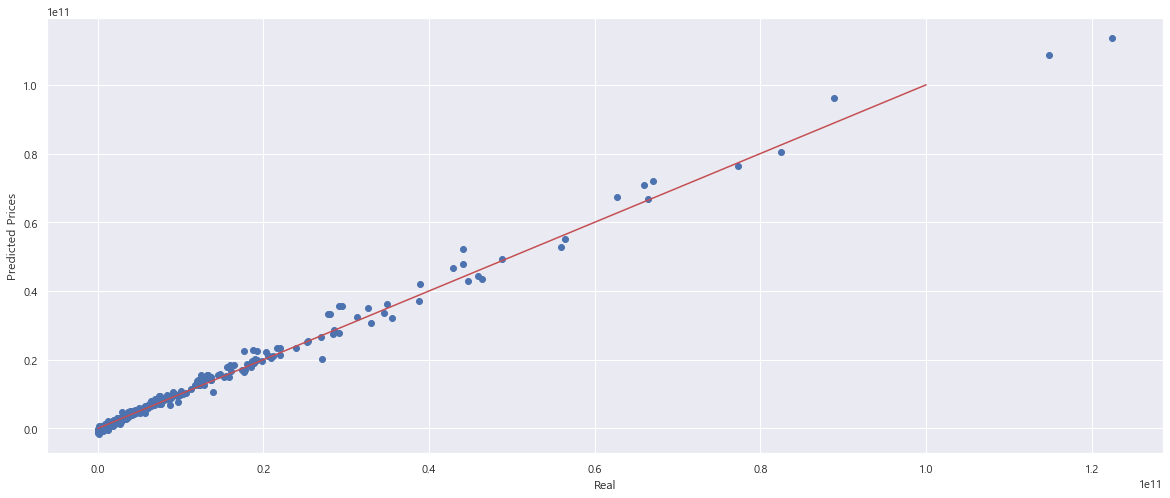

In [334]:
plt.scatter(y_test, pred_test)
plt.xlabel('Real')
plt.ylabel('Predicted Prices')
plt.plot([0, 1e+11], [0, 1e+11], 'r')
plt.show()

In [335]:
print('모델 정확도 : ', reg.score(X_test, y_test))

모델 정확도 :  0.9909743540510998


#### 스크린수만 포함

In [405]:
from sklearn.model_selection import train_test_split

X = movieDataTest_getDummies.drop(['영화명', '관객수', '상영횟수', '개봉일', '매출액', '국적', '배급사', '감독'], axis=1)
y = movieDataTest_getDummies['매출액']

In [407]:
# le_감독만 제거하기 위해 X, y 다시 설정
X = movieDataTest_getDummies.drop(['영화명', '개봉일', '매출액', '국적', '배급사', '감독'], axis=1)
y = movieDataTest_getDummies['매출액']

In [361]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [362]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [363]:
from sklearn.metrics import mean_squared_error

pred_tr = reg.predict(X_train)
pred_test = reg.predict(X_test)

rmse_tr = np.sqrt(mean_squared_error(y_train, pred_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

In [364]:
print('RMSE train : ', rmse_tr)
print('RMSE test : ', rmse_test)

RMSE train :  10436754416.908215
RMSE test :  10210437182.140875


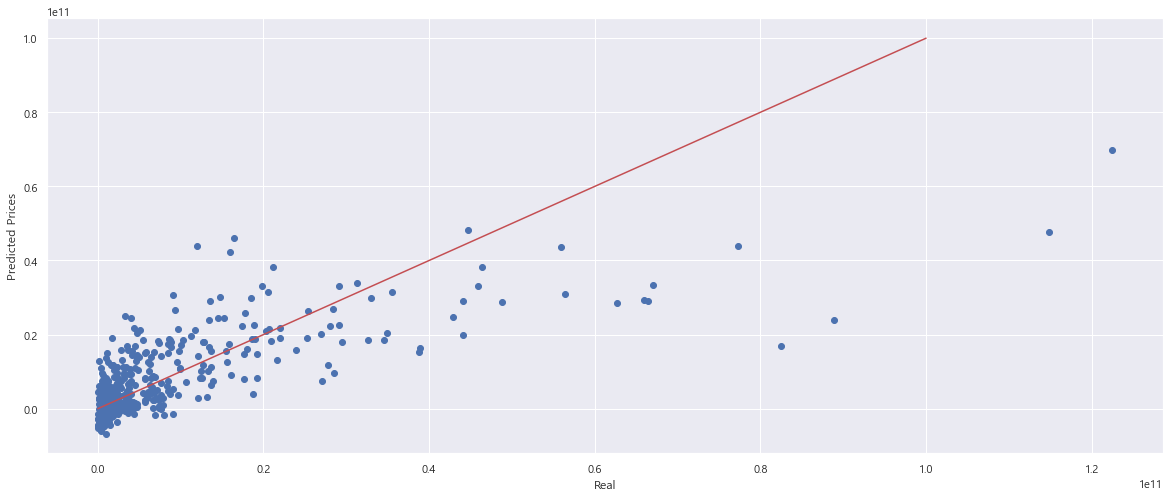

In [365]:
plt.scatter(y_test, pred_test)
plt.xlabel('Real')
plt.ylabel('Predicted Prices')
plt.plot([0, 1e+11], [0, 1e+11], 'r')
plt.show()

In [366]:
print('모델 정확도 : ', reg.score(X_test, y_test))

모델 정확도 :  0.5356248109067056


---

### 스케일 적용

In [149]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

mm = MinMaxScaler()
ss = StandardScaler()
rs = RobustScaler()

In [391]:
moviesForScaler = pd.read_excel('df5.xlsx')
moviesForScaler

,영화명,개봉일,매출액,관객수,스크린수,상영횟수,대표국적,국적,배급사,연령등급,장르,러닝타임,감독,개봉월,계절,le_감독,le_배급사,감독_참여작수
0,800,2020-12-10,135367500,15549,223,3738,중국,중국,TCO(주)더콘텐츠온,15세 관람가,전쟁,149,관후,12,겨울,0,0,1
1,1917,2020-02-19,7924722960,877017,932,91511,미국,미국,(주)스마일이엔티,15세 관람가,드라마,119,샘 멘데스,2,겨울,0,1,20
2,1987,2017-12-27,58169776145,1942077,1299,27619,한국,한국,CJ ENM,15세 관람가,드라마,129,장준환,12,겨울,1,0,14
3,#살아있다,2020-06-24,15968219900,1903992,1882,137073,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,드라마,98,조일형,6,여름,1,0,1
4,0.0MHz,2019-05-29,1088258860,137294,446,5998,한국,한국,(주)스마일이엔티,15세 관람가,공포,102,유선동,5,봄,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,히트,2011-10-13,783919500,110631,171,5960,한국,한국,(주)넥스트엔터테인먼트월드(NEW),청소년 관람불가,범죄,170,마이클 만,10,가을,0,0,23
2089,히트맨,2007-11-29,1094879000,163414,155,10301,미국,미국,이십세기폭스필름코퍼레이션,청소년 관람불가,액션,92,자비에르 젠스,11,가을,0,0,15
2090,히트맨,2020-01-22,20614278000,2406232,1122,87782,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,코미디,110,최원섭,1,겨울,1,0,6
2091,히트맨: 에이전트 47,2015-09-03,502308500,64157,272,4501,미국,미국,이십세기폭스코리아(주),15세 관람가,액션,98,알렉산더 바흐,9,가을,0,0,2


#### dummies 따로 저장

In [392]:
dummies = movieDataTest_getDummies[movieDataTest_getDummies.columns[10:]]

In [393]:
dummies

,le_감독,le_배급사,감독_참여작수,대표국적_기타,대표국적_남아프리카공화국,대표국적_네덜란드,대표국적_덴마크,대표국적_독일,대표국적_러시아,대표국적_미국,...,개봉월_7,개봉월_8,개봉월_9,개봉월_10,개봉월_11,개봉월_12,계절_가을,계절_겨울,계절_봄,계절_여름
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,0,1,20,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,1,0,14,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,0,0,23,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2089,0,0,15,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
2090,1,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2091,0,0,2,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0


#### StandardScaler

In [394]:
from sklearn.preprocessing import StandardScaler
# col_names = moviesForScaler.iloc[:, 2:5].columns
scaler = StandardScaler()
a = moviesForScaler.iloc[:, 2:5]
a['러닝타임'] = moviesForScaler['러닝타임']
a['감독_참여작수'] = moviesForScaler['감독_참여작수']
df_standard = scaler.fit_transform(a)

standard = pd.DataFrame(df_standard, columns = col_names)
standard

,0,1,2,3,4
0,-0.583420,-0.601261,-0.739375,1.988149,-0.774680
1,-0.076072,-0.151202,0.871679,0.449302,0.304893
2,3.196564,0.405220,1.705609,0.962251,-0.036025
3,0.447829,0.385323,3.030354,-0.627891,-0.774680
4,-0.521355,-0.537657,-0.232654,-0.422711,-0.490582
...,...,...,...,...,...
2088,-0.541178,-0.551587,-0.857534,3.065342,0.475352
2089,-0.520924,-0.524011,-0.893890,-0.935660,0.020795
2090,0.750443,0.647710,1.303414,-0.012352,-0.490582
2091,-0.559520,-0.575867,-0.628032,-0.627891,-0.717861


In [395]:
standard = standard.rename(columns={0:'관객수', 1:'스크린수', 2:'상영횟수', 3:'러닝타임', 4:'참여작수'})

In [396]:
dummies.columns

Index(['le_감독', 'le_배급사', '감독_참여작수', '대표국적_기타', '대표국적_남아프리카공화국', '대표국적_네덜란드',
       '대표국적_덴마크', '대표국적_독일', '대표국적_러시아', '대표국적_미국', '대표국적_벨기에', '대표국적_스웨덴',
       '대표국적_스페인', '대표국적_아이슬란드', '대표국적_영국', '대표국적_우크라이나', '대표국적_인도', '대표국적_일본',
       '대표국적_중국', '대표국적_캐나다', '대표국적_태국', '대표국적_페루', '대표국적_프랑스', '대표국적_핀란드',
       '대표국적_한국', '대표국적_헝가리', '대표국적_호주', '대표국적_홍콩', '연령등급_12세 관람가',
       '연령등급_15세 관람가', '연령등급_전체 관람가', '연령등급_청소년 관람불가', '장르_SF', '장르_가족',
       '장르_공연실황', '장르_공포', '장르_다큐멘터리', '장르_드라마', '장르_멜로/로맨스', '장르_모험',
       '장르_뮤지컬', '장르_미스터리', '장르_범죄', '장르_스릴러', '장르_애니메이션', '장르_액션', '장르_전쟁',
       '장르_코미디', '장르_판타지', '개봉월_1', '개봉월_2', '개봉월_3', '개봉월_4', '개봉월_5',
       '개봉월_6', '개봉월_7', '개봉월_8', '개봉월_9', '개봉월_10', '개봉월_11', '개봉월_12',
       '계절_가을', '계절_겨울', '계절_봄', '계절_여름'],
      dtype='object')

In [397]:
encoded_movies = pd.concat([standard, dummies], axis=1)

In [398]:
encoded_movies

,관객수,스크린수,상영횟수,러닝타임,참여작수,le_감독,le_배급사,감독_참여작수,대표국적_기타,대표국적_남아프리카공화국,...,개봉월_7,개봉월_8,개봉월_9,개봉월_10,개봉월_11,개봉월_12,계절_가을,계절_겨울,계절_봄,계절_여름
0,-0.583420,-0.601261,-0.739375,1.988149,-0.774680,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
1,-0.076072,-0.151202,0.871679,0.449302,0.304893,0,1,20,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3.196564,0.405220,1.705609,0.962251,-0.036025,1,0,14,0,0,...,0,0,0,0,0,1,0,1,0,0
3,0.447829,0.385323,3.030354,-0.627891,-0.774680,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,-0.521355,-0.537657,-0.232654,-0.422711,-0.490582,0,1,6,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,-0.541178,-0.551587,-0.857534,3.065342,0.475352,0,0,23,0,0,...,0,0,0,1,0,0,1,0,0,0
2089,-0.520924,-0.524011,-0.893890,-0.935660,0.020795,0,0,15,0,0,...,0,0,0,0,1,0,1,0,0,0
2090,0.750443,0.647710,1.303414,-0.012352,-0.490582,1,0,6,0,0,...,0,0,0,0,0,0,0,1,0,0
2091,-0.559520,-0.575867,-0.628032,-0.627891,-0.717861,0,0,2,0,0,...,0,0,1,0,0,0,1,0,0,0


In [315]:
encoded_movies.to_excel('encoded_movies.xlsx')

In [348]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [349]:
reg.fit(X_train, y_train)
print('모델 정확도 : ', reg.score(X_test, y_test))

모델 정확도 :  0.9909743540510998


In [353]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(['관객수', '상영횟수'], axis=1), y, test_size=0.2, random_state=13)

In [354]:
reg.fit(X_train, y_train)
print('모델 정확도 : ', reg.score(X_test, y_test))

모델 정확도 :  0.5356248109067056


#### MinMaxScaler

In [409]:
# col_names = moviesForScaler.iloc[:, 2:5].columns
scaler = MinMaxScaler()
a = moviesForScaler.iloc[:, 2:5]
a['러닝타임'] = moviesForScaler['러닝타임']
a['감독_참여작수'] = moviesForScaler['감독_참여작수']
df_standard = scaler.fit_transform(a)

standard = pd.DataFrame(df_standard, columns = col_names)
standard

,0,1,2,3,4
0,0.000716,0.000459,0.050921,0.500000,0.000000
1,0.056507,0.049389,0.222842,0.368421,0.136691
2,0.416386,0.109882,0.311833,0.412281,0.093525
3,0.114119,0.107719,0.453201,0.276316,0.000000
4,0.007541,0.007374,0.104995,0.293860,0.035971
...,...,...,...,...,...
2088,0.005361,0.005860,0.038312,0.592105,0.158273
2089,0.007589,0.008858,0.034433,0.250000,0.100719
2090,0.147396,0.136246,0.268914,0.328947,0.035971
2091,0.003344,0.003220,0.062803,0.276316,0.007194


In [410]:
standard = standard.rename(columns={0:'관객수', 1:'스크린수', 2:'상영횟수', 3:'러닝타임', 4:'참여작수'})

In [411]:
encoded_movies = pd.concat([standard, dummies], axis=1)

In [413]:
encoded_movies

,관객수,스크린수,상영횟수,러닝타임,참여작수,le_감독,le_배급사,감독_참여작수,대표국적_기타,대표국적_남아프리카공화국,...,개봉월_7,개봉월_8,개봉월_9,개봉월_10,개봉월_11,개봉월_12,계절_가을,계절_겨울,계절_봄,계절_여름
0,0.000716,0.000459,0.050921,0.500000,0.000000,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
1,0.056507,0.049389,0.222842,0.368421,0.136691,0,1,20,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.416386,0.109882,0.311833,0.412281,0.093525,1,0,14,0,0,...,0,0,0,0,0,1,0,1,0,0
3,0.114119,0.107719,0.453201,0.276316,0.000000,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.007541,0.007374,0.104995,0.293860,0.035971,0,1,6,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,0.005361,0.005860,0.038312,0.592105,0.158273,0,0,23,0,0,...,0,0,0,1,0,0,1,0,0,0
2089,0.007589,0.008858,0.034433,0.250000,0.100719,0,0,15,0,0,...,0,0,0,0,1,0,1,0,0,0
2090,0.147396,0.136246,0.268914,0.328947,0.035971,1,0,6,0,0,...,0,0,0,0,0,0,0,1,0,0
2091,0.003344,0.003220,0.062803,0.276316,0.007194,0,0,2,0,0,...,0,0,1,0,0,0,1,0,0,0


In [414]:
X_train, X_test, y_train, y_test = train_test_split(encoded_movies.drop(['le_감독'], axis=1), y, test_size=0.2, random_state=13)

In [415]:
reg.fit(X_train, y_train)
print('모델 정확도 : ', reg.score(X_test, y_test))

모델 정확도 :  0.9999999999999523


#### RobustScaler

In [367]:
# col_names = moviesForScaler.iloc[:, 2:5].columns
scaler = RobustScaler()
a = moviesForScaler.iloc[:, 2:5]
a['러닝타임'] = moviesForScaler['러닝타임']
a['감독_참여작수'] = moviesForScaler['감독_참여작수']
df_standard = scaler.fit_transform(a)

standard = pd.DataFrame(df_standard, columns = col_names)
standard

,0,1,2,3,4
0,-0.341274,-0.350066,-0.431461,1.739130,-0.571429
1,0.523637,0.379084,1.161798,0.434783,0.785714
2,6.102719,1.280554,1.986517,0.869565,0.357143
3,1.416766,1.248319,3.296629,-0.478261,-0.571429
4,-0.235467,-0.247020,0.069663,-0.304348,-0.214286
...,...,...,...,...,...
2088,-0.269260,-0.269588,-0.548315,2.652174,1.000000
2089,-0.234732,-0.224912,-0.584270,-0.739130,0.428571
2090,1.932652,1.673416,1.588764,0.043478,-0.214286
2091,-0.300529,-0.308924,-0.321348,-0.478261,-0.500000


In [368]:
standard = standard.rename(columns={0:'관객수', 1:'스크린수', 2:'상영횟수', 3:'러닝타임', 4:'참여작수'})

In [369]:
encoded_movies = pd.concat([standard, dummies], axis=1)

In [373]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [374]:
reg.fit(X_train, y_train)
print('모델 정확도 : ', reg.score(X_test, y_test))

모델 정확도 :  0.5356248109067056


- 3종류의 scaler를 모두 사용해도 모델 정확도에는 영향을 미치지 않는다...

In [380]:
from statsmodels.formula.api import ols

In [381]:
ols('매출액 ~ 스크린수 + 러닝타임 + le_감독 + le_배급사 + 감독_참여작수', data=moviesForScaler).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    매출액   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     456.2
Date:                Tue, 03 Jan 2023   Prob (F-statistic):               0.00
Time:                        20:50:18   Log-Likelihood:                -51287.
No. Observations:                2093   AIC:                         1.026e+05
Df Residuals:                    2087   BIC:                         1.026e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.058e+10   1.36e+09     -7.786      0.000   -1.32e+10   -7.91e+09
스크린수        2.124e+07   5.76e+05     36.900      0.000    2.01e+07    2.24e+07
러닝타임        5.405e+07   1.33e+07      4.063      0.000     2.8e+07    8.01e+07
le_감독        8.39e+09   6.33e+08     13.246      0.000    7.15e+09    9.63e+09
le_배급사      8.358e+08   5.79e+08      1.444      0.149   -2.99e+08    1.97e+09
감독_참여작수     2.609e+07   1.36e+07      1.913      0.056   -6.52e+05    5.28e+07
==============================================================================
Omnibus:                     1268.972   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29688.221
Skew:                           2.419   Prob(JB):                         0.00
Kurtosis:                      20.805   Cond. No.                     4.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Df Residuals: 자유도(전체 표본 수 - 종속변수1개 - 독립변수10개)
- Df Model: 독립변수의 개수
- R-squared: 결정계수 --> 전체 데이터 중 해당 회귀모델이 설명할 수 있는 데이터의 비율, 회귀식의 설명력을 나타낸다.
- Adj. R-squared: 회귀분석은 변수가 추가될 때 항상 설명력이 올라가기만 하기 때문에, 설명력에 영향이 거의 없는 변수라 할지라도 결과적으로 설명력을 높혀 모델의 설명력이 실제보다 높게 나올 수 있다. 따라서 독립변수의 개수에 따라 R-squared를 조정해줘야 한다.
- F-statistics: F통계량을 뜻한다. F통계량은 MSR/MSE로 구할 수 있다. 도출된 회귀식이 통계적으로 유의한지 확인. 0에 가까울수록 좋음
- Prob: F통계량에 해당하는 P-value를 의미한다. 회귀식이 유의미한지 확인. 0.05 이하일 경우 유의한 것으로 판단
- Log-Likelihood: 로그우도, 생성된 모델이 주어진 데이터를 생성할 가능성의 수치적 기표. 모델을 생성하는 과정에서 각 변수에 대한 계수값을 비교할 때 사용
- AIC, BIC: Log-Likelihood를 독립변수의 수로 보정한 값, 값이 작을 수록 좋음
  - AIC: 표본의 개수와 모델의 복잡성을 기반으로 모델을 평가하며, 수치가 낮을 수록 좋음
  - BIC: AIC와 유사하나 패널티를 부여하여 AIC보다 모델 평가 성능이 더 좋으며, 수치가 낮을 수록 좋음
- Intercept coef: 회귀식의 절편값
- 각 column의 coef: 각 독립변수의 회귀계수(기울기)
- std err: 계수의 표준오차(표본 통계량의 표준 편차), 값이 작을 수록 좋음
- t: 독립변수와 종속변수간에 선형관계(관련성)가 존재하는 정도, 값이 클수록 상관도가 큼
  - t 값이 크다 = 표준 편차가 작다 = 독립-종속변수 간 상관도 높음
  - t 값이 작다 = 표준 편차가 크다 = 독립-종속변수 간 상관도 낮음
- P>|t|: p-value(유의확률), 귀무가설이 맞다고 가정할 때 얻은 결과보다 극단적인 결과가 실제로 관측될 확률, 일반적으로 유의수준 5%보다 p값이 작으면(p < 0.05), “통계적으로 유의미하다”고 판단
- Omnibus: 디아고스티노 검정(귀무가설 검정), 비대칭도와 첨도를 결합한 정규성 테스트, 값이 클수록 정규 분포를 따른다는 의미
- Prob(Omnibus): 디아고스티노 검정이 유의한지 판단, 0.05 이하일 경우 유의하다고 판단
- Skew: 왜도, 평균 주위의 잔차들의 대칭하는지를 보는 것이며, 0에 가까울수록 대칭
- Kurtosis: 첨도, 잔차들의 분포 모양이며, 3에 가까울 수록 정규분포이다. (음수이면 평평한 형태, 양수는 뾰족한 형태)

---

#### XGBRegressor(관객수, 상영횟수, 스크린수 미포함)

In [420]:
import xgboost

In [421]:
X

,관객수,스크린수,상영횟수,러닝타임,le_감독,le_배급사,감독_참여작수,대표국적_기타,대표국적_남아프리카공화국,대표국적_네덜란드,...,개봉월_7,개봉월_8,개봉월_9,개봉월_10,개봉월_11,개봉월_12,계절_가을,계절_겨울,계절_봄,계절_여름
0,15549,223,3738,149,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,877017,932,91511,119,0,1,20,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1942077,1299,27619,129,1,0,14,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,1903992,1882,137073,98,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,137294,446,5998,102,0,1,6,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,110631,171,5960,170,0,0,23,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2089,163414,155,10301,92,0,0,15,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2090,2406232,1122,87782,110,1,0,6,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2091,64157,272,4501,98,0,0,2,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [422]:
y

0         135367500
1        7924722960
2       58169776145
3       15968219900
4        1088258860
           ...     
2088      783919500
2089     1094879000
2090    20614278000
2091      502308500
2092     9930518906
Name: 매출액, Length: 2093, dtype: int64

In [472]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(['관객수', '상영횟수'], axis=1), y, test_size=0.2, random_state=13)

#### 학습

In [473]:
xgbr = xgboost.XGBRegressor(n_estimators=400, learning_rate=0.1, max_depth=3)
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

#### Column별 중요도

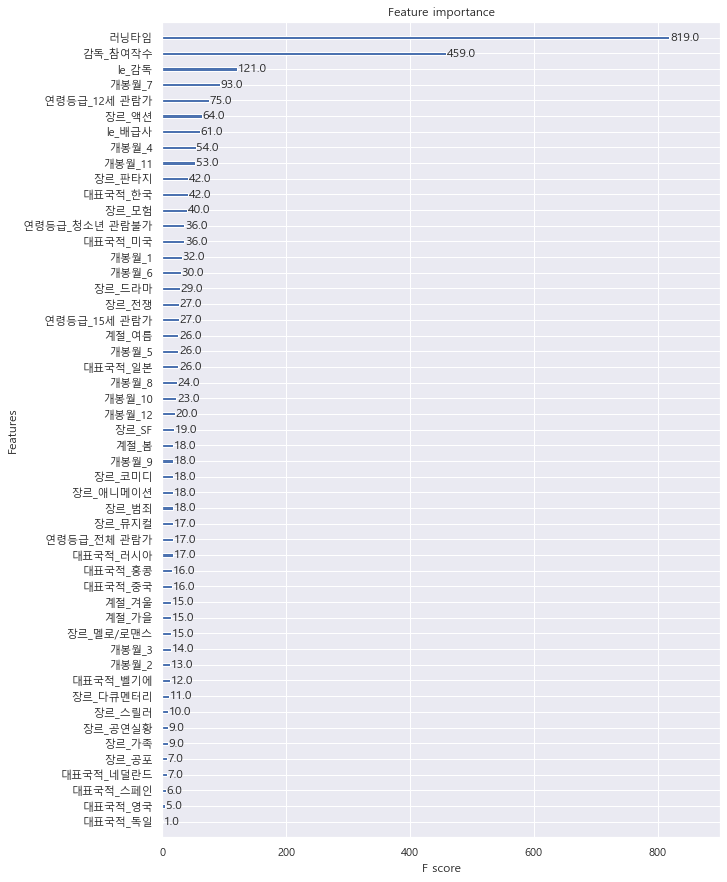

In [448]:
ax = xgboost.plot_importance(xgbr)
fig = ax.figure
fig.set_size_inches(10, 15)

#### 예측

In [440]:
pred = xgbr.predict(X_test)
pred

array([ 3.24854323e+09,  7.97907661e+09,  3.00249457e+10,  5.03269018e+09,
        1.17419889e+10,  1.13638902e+10, -2.53137664e+09,  3.25322624e+09,
        4.24239923e+09,  2.28255846e+10,  1.47146660e+10,  1.15766467e+10,
        2.00204659e+09,  4.18512896e+10,  3.24123059e+09,  6.40595046e+09,
        2.81265101e+09,  1.92933850e+09, -1.73135155e+09,  1.71427571e+09,
        7.17830144e+09, -1.00771315e+09,  5.97843968e+09,  1.34938163e+10,
       -1.17324979e+09,  3.86745165e+09,  9.68113766e+09,  1.82837637e+10,
        1.02448323e+10,  3.95782733e+09,  3.83926190e+10,  1.47787284e+10,
        2.39884042e+10,  2.12755494e+09,  4.09462702e+10,  1.04007155e+09,
        1.21857116e+10,  2.23317361e+10,  4.03461581e+09,  3.82690427e+10,
        1.26002714e+09,  3.02018724e+10,  9.24145562e+09,  4.62891674e+09,
        8.25298893e+09,  5.08046541e+09,  9.63149619e+09,  1.82812838e+09,
        2.87755443e+09,  4.49240525e+09,  5.21907200e+09,  3.48608922e+09,
        1.49170534e+10,  

In [459]:
X_test

,러닝타임,le_감독,le_배급사,감독_참여작수,대표국적_기타,대표국적_남아프리카공화국,대표국적_네덜란드,대표국적_덴마크,대표국적_독일,대표국적_러시아,...,개봉월_7,개봉월_8,개봉월_9,개봉월_10,개봉월_11,개봉월_12,계절_가을,계절_겨울,계절_봄,계절_여름
1940,95,0,0,28,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
142,125,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1150,141,0,0,38,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
727,92,0,0,3,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
320,130,0,0,9,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,108,0,0,17,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
681,117,0,0,133,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
576,102,0,0,7,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1915,97,0,0,15,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [441]:
r_sq = xgbr.score(X_train, y_train)
print(r_sq)

0.6810005638075327


In [449]:
pred_tr = xgbr.predict(X_train)
pred_test = xgbr.predict(X_test)

rmse_tr = np.sqrt(mean_squared_error(y_train, pred_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

print('RMSE train : ', rmse_tr)
print('RMSE test : ', rmse_test)

RMSE train :  8720825013.30765
RMSE test :  12667030795.930693


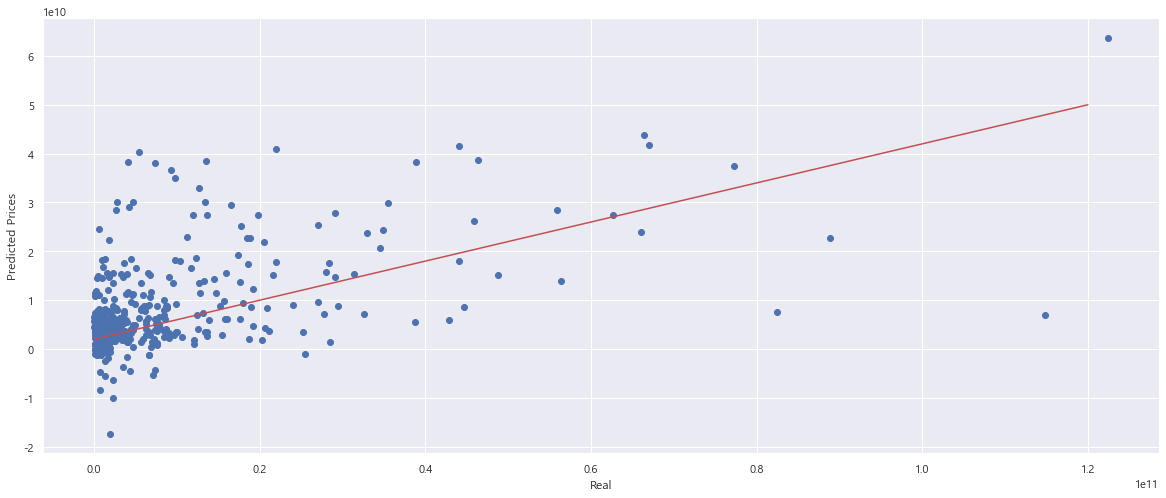

In [458]:
plt.scatter(y_test, pred_test)
plt.xlabel('Real')
plt.ylabel('Predicted Prices')
plt.plot([0, 1.2e+11], [0.02e+11, 0.5e+11], 'r')
plt.show()

---

In [469]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
def movie_change(list):
    list_colum = ['스크린수', '러닝타임', 'le_감독', 'le_배급사', '감독_참여작수', '대표국적_기타',
       '대표국적_남아프리카공화국', '대표국적_네덜란드', '대표국적_덴마크', '대표국적_독일', '대표국적_러시아',
       '대표국적_미국', '대표국적_벨기에', '대표국적_스웨덴', '대표국적_스페인', '대표국적_아이슬란드', '대표국적_영국',
       '대표국적_우크라이나', '대표국적_인도', '대표국적_일본', '대표국적_중국', '대표국적_캐나다', '대표국적_태국',
       '대표국적_페루', '대표국적_프랑스', '대표국적_핀란드', '대표국적_한국', '대표국적_헝가리', '대표국적_호주',
       '대표국적_홍콩', '연령등급_12세 관람가', '연령등급_15세 관람가', '연령등급_전체 관람가',
       '연령등급_청소년 관람불가', '장르_SF', '장르_가족', '장르_공연실황', '장르_공포', '장르_다큐멘터리',
       '장르_드라마', '장르_멜로/로맨스', '장르_모험', '장르_뮤지컬', '장르_미스터리', '장르_범죄', '장르_스릴러',
       '장르_애니메이션', '장르_액션', '장르_전쟁', '장르_코미디', '장르_판타지', '개봉월_1', '개봉월_2',
       '개봉월_3', '개봉월_4', '개봉월_5', '개봉월_6', '개봉월_7', '개봉월_8', '개봉월_9', '개봉월_10',
       '개봉월_11', '개봉월_12', '계절_가을', '계절_겨울', '계절_봄', '계절_여름']
    list_contry = ['기타','남아프리카공화국','네덜란드','덴마크','독일','러시아','미국','벨기에','스웨덴','스페인',
                   '아이슬란드','영국','우크라이나','인도','일본','중국','캐나다','태국','페루','프랑스','핀란드',
                   '한국','헝가리','호주','홍콩']
    list_genre = ['SF','가족','공연실황','공포','다큐멘터리','드라마',
                  '멜로/로맨스','모험','뮤지컬','미스터리','범죄','스릴러','애니메이션','액션','전쟁','코미디','판타지']
    list_rating = ['12세 관람가', '15세 관람가', '전체 관람불가', '청소년 관람가']
    list_month = [1,  2,  3,  4,  5, 6, 7,  8,9,  10,  11,  12]
    list_season = ['가을', '겨울', '봄', '여름']
    moviesForScaler = pd.DataFrame(columns=list_colum)
    list_A = [0 for i in range(62)]
    for i in range(5):
        if i == 0:
            for j in range(25):
                if list[1] == list_contry[j]:
                    list_A[j] = 1
        if i == 1:
            for j in range(4):
                if list[2] == list_rating[j]:
                    list_A[j + 25] = 1
        if i == 2:
            for j in range(17):
                if list[3] == list_genre[j]:
                    list_A[j + 29] = 1
        if i == 3:
            for j in range(12):
                if list[5] == list_month[j]:
                    list_A[j + 46] = 1
        if i == 4:
            for j in range(4):
                if list[6] == list_season[j]:
                    list_A[j + 58] = 1
    list_B = [0,0,0,0,0]
    list_B[0] = list[0]
    list_B[1] = list[4]
    list_B[2] = list[7]
    list_B[3] = list[8]
    list_B[4] = list[9]
    list_C = list_B + list_A
    A = pd.DataFrame([list_C], columns=list_colum)
    # '스크린수','국적','연령등급','장르','러닝타임','개봉월','계절','le_감독','le_배급사','감독_참여작수'
    # 스크린수 러닝타임 	참여작수	le_감독	le_배급사
    # '스크린수', '러닝타임', 'le_감독', 'le_배급사', '감독_참여작수'
    return A

In [476]:
# '스크린수','국적','연령등급','장르','러닝타임','개봉월','계절','le_감독','le_배급사','감독_참여작수'

list = [624,'한국','12세 관람가','드라마',116, 2, '겨울', 0, 0, 6]

In [471]:
movie_change(list)

,스크린수,러닝타임,le_감독,le_배급사,감독_참여작수,대표국적_기타,대표국적_남아프리카공화국,대표국적_네덜란드,대표국적_덴마크,대표국적_독일,...,개봉월_7,개봉월_8,개봉월_9,개봉월_10,개봉월_11,개봉월_12,계절_가을,계절_겨울,계절_봄,계절_여름
0,624,116,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [474]:
# 기존 데이터 예측
pred_list = xgbr.predict(movie_change(list))
pred_list

array([5.985066e+09], dtype=float32)

In [477]:
# '스크린수','국적','연령등급','장르','러닝타임','개봉월','계절','le_감독','le_배급사','감독_참여작수'

# 감독만 봉준호(major 감독)

list_1 = [624,'한국','12세 관람가','드라마',116, 2, '겨울', 1, 0, 6]

In [478]:
movie_change(list_1)

,스크린수,러닝타임,le_감독,le_배급사,감독_참여작수,대표국적_기타,대표국적_남아프리카공화국,대표국적_네덜란드,대표국적_덴마크,대표국적_독일,...,개봉월_7,개봉월_8,개봉월_9,개봉월_10,개봉월_11,개봉월_12,계절_가을,계절_겨울,계절_봄,계절_여름
0,624,116,1,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [479]:
xgbr.predict(movie_change(list_1))

array([1.5793129e+10], dtype=float32)

In [480]:
15793129000 - 5985066000

9720000000

In [481]:
# '스크린수','국적','연령등급','장르','러닝타임','개봉월','계절','le_감독','le_배급사','감독_참여작수'

# 겨울 --> 여름 / 2월 --> 7월

list_2 = [624,'한국','12세 관람가','드라마',116, 7, '여름', 0, 0, 6]

In [482]:
xgbr.predict(movie_change(list_2))

array([1.2645946e+10], dtype=float32)

In [ ]:
12645946000

In [483]:
# '스크린수','국적','연령등급','장르','러닝타임','개봉월','계절','le_감독','le_배급사','감독_참여작수'

# 드라마 --> 액션

list_3 = [624,'한국','12세 관람가','액션',116, 2, '겨울', 0, 0, 6]

In [484]:
xgbr.predict(movie_change(list_3))

array([7.663292e+09], dtype=float32)

In [ ]:
7663292000

In [485]:
len(X_train)

1674

In [486]:
len(X_test)

419

In [487]:
1674 + 419

2093

In [507]:
# '스크린수','국적','연령등급','장르','러닝타임','개봉월','계절','le_감독','le_배급사','감독_참여작수'

# 닥터스트레인지

list_4 = [2691,'미국','12세 관람가','액션',126, 5, '여름', 1, 1, 50]

In [508]:
float(xgbr.predict(movie_change(list_4)))

69929656320.0

---

In [504]:
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor(max_depth=20, max_features=100)
RFR.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features=100)

In [509]:
float(RFR.predict(movie_change(list_4)))

69187884174.23